# DSCI100: Group31 Project Report
### Members
- Divya Gupta
- Arshdeep Jassi
- Cassiel Jung
- Lily Zhang

## 1.0 Introduction
When watching tennis games, players who have high rank seem to have a similar physique. Our team got curious if there is a certain favorable body type for a tennis player. Thus, throughout this project, we are going to answer the question **“What is the relationship between the physique of players and their probability of winning?”**. To answer the question, the dataset *‘Game results for Top 500 Players from 2017-2019’* will be used which contains the data of each tennis game played by Top 500 Players. Each row corresponds to each game and it includes information of players such as their height, age, and hand.

## 2.0 Method & Results
Libraries to use:
1. tidyverse: to use read_csv/ggplot and many other basic data analysis functions
2. repre: to represent string/binary variables
3. tidymodels: to use regression model later

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### 2.1 Read data from the web
Loading dataset from the google drive using read_csv() function

In [3]:
tennis_raw_data <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(tennis_raw_data)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


### 2.2 Clean and Wrangling the dataset

The original data downloded from web contains information of each game. However, since we want to analyze how each player's physique is related to their probability of winning, we need to clean the data a bit. We followed below process to get the probability of winning per year for each players.
1. round up winner's age with round(). Our dataset contains data from 2017 to 2019 and represent age in decimal, to calculate probability of winning in each year round up the age to whole number was required. 
3. get winner's height, hand and number of winning in each year using group_by() and summarise() functions.
4. remove duplicate using unique() function.


In [4]:
winner_data <- tennis_raw_data %>%
                mutate(age = round(winner_age, digit = 0)) %>%
                group_by(winner_id, age) %>%
                summarise(height = winner_ht, hand = winner_hand, num_winning = n()) %>%
                rename(player_id = winner_id) %>%
                unique()

loser_data <- tennis_raw_data %>%
                mutate(age = round(winner_age, digit = 0)) %>%
                group_by(loser_id, age) %>%
                summarise(height = loser_ht, hand = loser_hand, num_losing = n()) %>%
                rename(player_id = loser_id) %>%
                unique()

tennis_clean <- bind_rows(winner_data, loser_data) %>%
                as_tibble() %>%
                replace_na(list(num_winning = 0, num_losing = 0)) %>%
                group_by(player_id, age) %>%
                summarize(height = height, 
                          hand = hand, 
                          num_winning = sum(num_winning), 
                          num_losing = sum(num_losing),
                          prob_winning = (num_winning / (num_winning + num_losing))) %>%
                unique()
tennis_clean <- tennis_clean[complete.cases(tennis_clean),]

head(tennis_clean)

`summarise()` regrouping output by 'winner_id', 'age' (override with `.groups` argument)

`summarise()` regrouping output by 'loser_id', 'age' (override with `.groups` argument)

`summarise()` regrouping output by 'player_id', 'age' (override with `.groups` argument)



player_id,age,height,hand,num_winning,num_losing,prob_winning
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
100644,20,198,R,45,2,0.9574468
100644,21,198,R,48,6,0.8888889
100644,22,198,R,42,8,0.8400000
100644,23,198,R,3,4,0.4285714
100644,24,198,R,0,3,0.0000000
100644,25,198,R,0,2,0.0000000


### 2.3 Splitting dataset
Split dataset into two: 75% of train set and 25% of test set

In [5]:
set.seed(42) 
tennis_split <- initial_split(tennis_clean, prop = 0.75)  
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

### 2.4 Summarize data
#### 2.4.1 Summarize quantitative variables
One of the metrics that can be explored is the average values of the quantitative variables we are considering in the analysis such as height and age. The table below shows the average height (in cm) and age (years) of both the winners and the losers. As seen below, the average height and age of both winners and losers is similar.

In [6]:
tennis_avg_summarization <- tennis_train %>% 
    select(winner_ht, winner_age, loser_ht, loser_age) %>% 
    summarize(avg_win_height = mean(winner_ht, na.rm = TRUE),
              avg_win_age = mean(winner_age, na.rm = TRUE), 
              avg_loser_height = mean(loser_ht, na.rm = TRUE), 
              avg_loser_age = mean(loser_age, na.rm = TRUE))

tennis_avg_summarization

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `winner_ht` doesn't exist.


#### 2.4.2 Summarize categorical variable
There is one more variable we are considering for the analysis which is handedness of the players. Since it is a categorical variable, to explore the number of games won with each dominant hand, we can just count up the number of winners for each dominant hand. This can be seen in the following table.

In [ ]:
tennis_num_winners_hand <- tennis_train %>% 
    select(winner_hand) %>% 
    group_by(winner_hand) %>% 
    summarize(number_winners = n())

tennis_num_winners_hand

### 2.5 Visualize summarized data
#### 2.5.1 Winning games vs Winner's handedness
By using the tennis_num_winners_hand assigned previously, a visual representation can be created that compares the number of games won with the different handedness of players using bar plots. Colour-blind friendly colours were also added to help better visualize the plot. This was done using the ggplot and geom_bar functions.

In [ ]:
options(repr.plot.height = 7, repr.plot.width = 12)
library(RColorBrewer)

winning_hand_visual <- ggplot(tennis_num_winners_hand, aes(x = winner_hand, y = number_winners, fill = winner_hand)) +
                            geom_bar(stat = "identity") +
                            labs(x = "Main hand", y = "Number of games won", fill = "Winner's main hand used for the game") +
                            ggtitle("Winning games vs. Winner's main hand") +
                            theme(text = element_text(size = 20)) +
                            scale_fill_brewer(palette = 'Paired')

winning_hand_visual



#### 2.5.2 Winning games vs Winner's height
By using the testing data set, a histogram can be produced that visualizes the distribution of winning games for winner’s heights. This was done using the ggplot and geom_histogram functions.

In [ ]:
options(repr.plot.height = 7, repr.plot.width = 8)
winning_height_visual <- tennis_train %>%
                    ggplot(aes(x = winner_ht)) +
                    geom_histogram(bins = 20) +
                    labs(x = "Winner's height (cm)", y = "Number of games won") +
                    ggtitle("Winning games vs. Winner's height") +
                    theme(text = element_text(size = 20))
                    

winning_height_visual


### 2.4.3 Winning games vs Winner's age
Similar to the previous graph and using the same data, a histogram is also used to visualize the distribution of the winning games for the winner’s age. This was done using the ggplot and geom_histogram functions.

In [ ]:
options(repr.plot.height = 7, repr.plot.width = 8)
winning_age_visual <- tennis_train %>%
                    ggplot(aes(x = winner_age)) +
                    geom_histogram(bins = 30) +
                    labs(x = "Winner's age (years)", y = "Number of games won") +
                    ggtitle("Winning games vs. Winner's age") +
                    theme(text = element_text(size = 20))
                    

winning_age_visual


### 2.5 Data Analysis

In [ ]:
# create recipe
tennis_recipe <- recipe()

#### 2.5.1 knn Regression

In [7]:
set.seed(1234)
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("regression") 

tennis_recipe <- recipe(prob_winning ~ height + age, data = tennis_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [8]:
set.seed(1234)
tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = prob_winning)
tennis_workflow <- workflow() %>%
                add_recipe(tennis_recipe) %>%
                add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
set.seed(2019)
gridvals <- tibble(neighbors = seq(from = 1, to = 100))

tennis_results <- tennis_workflow %>%
            tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
            collect_metrics()

head(tennis_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.449294547,5,0.010131054,Model001
1,rsq,standard,0.009077755,5,0.003357239,Model001
2,rmse,standard,0.380872758,5,0.007752158,Model002
2,rsq,standard,0.024894449,5,0.008858549,Model002
3,rmse,standard,0.369110389,5,0.005424317,Model003
3,rsq,standard,0.019236318,5,0.007653759,Model003


In [10]:
set.seed(2020)

tennis_min <- tennis_results %>%
   filter(.metric == "rmse") %>%
   arrange(mean) %>% 
   slice(1)

tennis_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,0.3146444,5,0.007244159,Model041


In [11]:
set.seed(1234)

k_min <- tennis_min %>%
         pull(neighbors)
tennis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

tennis_best_fit <- workflow() %>%
         add_recipe(tennis_recipe) %>%
         add_model(tennis_best_spec) %>%
         fit(data = tennis_train)

tennis_summary <- tennis_best_fit %>%
          predict(tennis_test) %>%
          bind_cols(tennis_test) %>%
          metrics(truth = prob_winning, estimate = .pred)

tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.32142389
rsq,standard,0.07309399
mae,standard,0.23910136


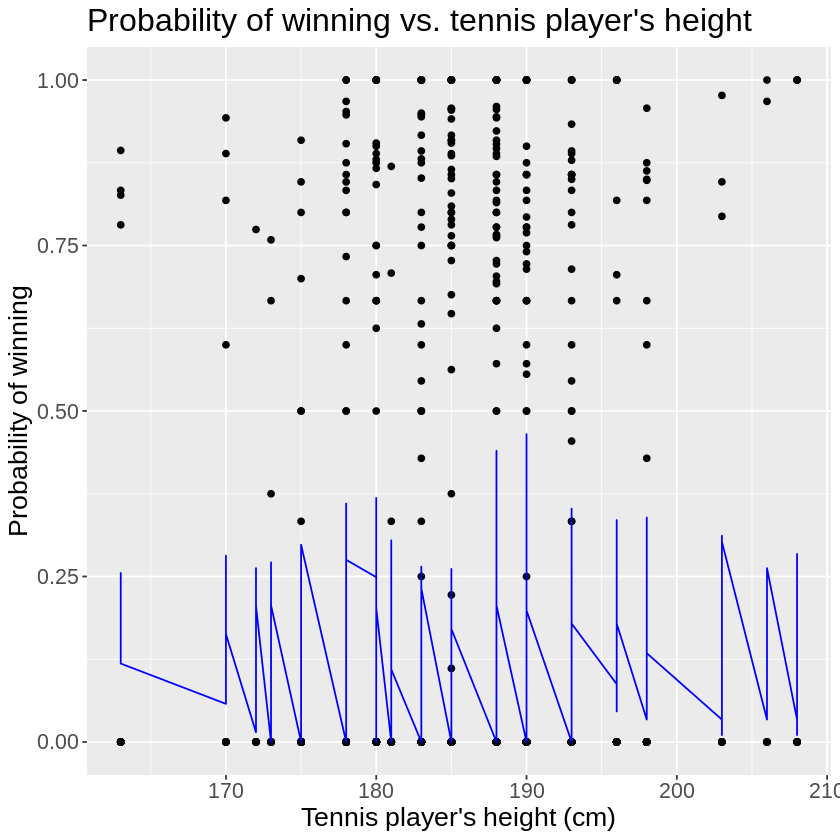

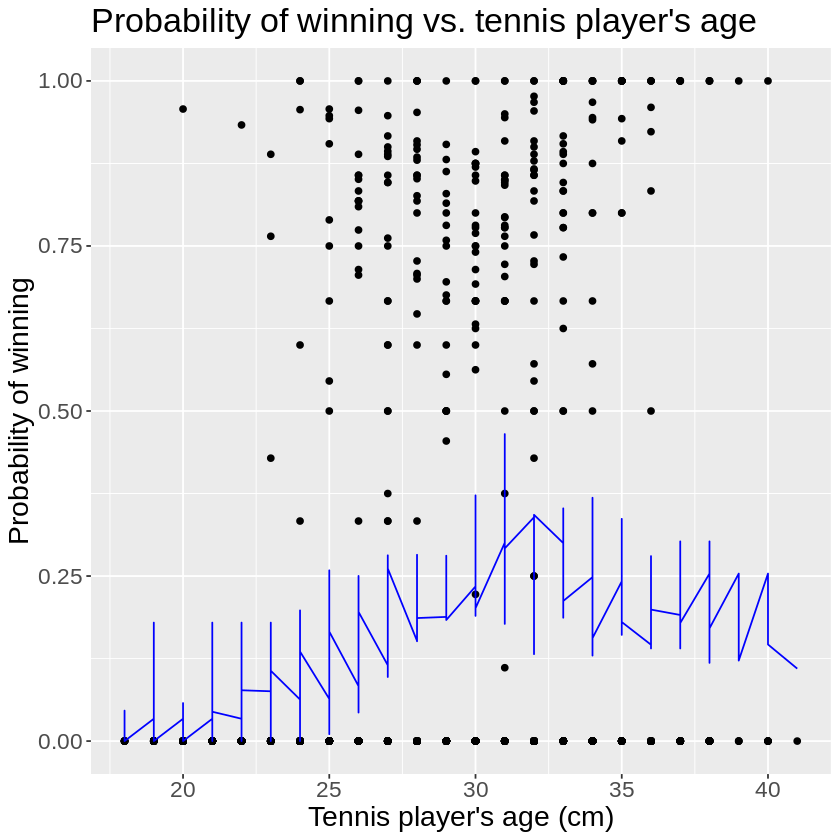

In [12]:
set.seed(2019)

options(repr.plot.width = 7, repr.plot.height = 7)

tennis_preds <- predict(tennis_best_fit, tennis_train) %>%
          bind_cols(tennis_train)

tennis_plot_height <- ggplot(tennis_preds, aes(x = height, y = prob_winning)) +
            geom_point() +
            geom_line(data = tennis_preds,
            mapping = aes(x = height, y = .pred), color = "blue") +
            xlab("Tennis player's height (cm)") +
            ylab("Probability of winning") + 
            ggtitle("Probability of winning vs. tennis player's height") + 
            theme(text = element_text(size = 16))

tennis_plot_age <- ggplot(tennis_preds, aes(x = age, y = prob_winning)) +
            geom_point() +
            geom_line(data = tennis_preds,
            mapping = aes(x = age, y = .pred), color = "blue") +
            xlab("Tennis player's age (cm)") +
            ylab("Probability of winning") + 
            ggtitle("Probability of winning vs. tennis player's age") + 
            theme(text = element_text(size = 17))

tennis_plot_height
tennis_plot_age

## 3.0 Discussion


## 4.0 References

